# Analysis Of Hotel Prices During World Cup 2022
#### The hotel prices of Banyan Tree Doha at La Cigale Mushaireb from November 20th to December 23rd 


**The 2022 FIFA World Cup** was an international football tournament played from **November 20th to December 18th, 2022 in Qatar**. Qatar was visited by about *1.5 million tourists*, and hotel companies took advantage of this. Due to the increased demand for accommodation, hotel companies increased their **accommodation prices**. 

On the example of *Banyan Tree Doha At La Cigale Mushaireb in Doha*, we will analyze the room prices in the period **from November 18th to December 23th**. The collected prices refer to accommodation for *two people with breakfast*. Prices are shown in euros. The hotel has *2 types of standard rooms, 4 types of suite and 5 types of residence*. In this analysis, data was collected for only **5 categories of rooms**, 2 standard rooms and 3 apartments:

- Urban Retreat (Standard Room)
- Serenity Retreat (Standard Room)
- Urban Suite (Suite)
- Serenity Club Suite (Suite)
- Harmony Horizon Club Suite (Suite)

It should be noted that there are many **missing values**. Missing values in this analysis mean that that room category was **not available** for booking on a certain day and therefore the price was not displayed. The percentage of missing values for each room category is between *33% and 50%* of entire values in a column. In this analysis we will try to **fill in all missing values** with the *estimated prices* that we will get based on prices from other room categories that don't have missing values.

# Imports and Understanding Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
banyan_tree = pd.read_excel('BANYAN TREE DOHA AT LA CIGALE MUSHAIREB.xlsx', parse_dates=True, index_col=[0], sheet_name='Sheet2')
#banyan_tree.head()
#banyan_tree.describe()
banyan_tree.isna().mean()*100

Urban Retreat                 44.444444
Serenity Retreat              50.000000
Urban Suite                   33.333333
Serenity Club Suite           36.111111
Harmony Horizon Club Suite    44.444444
dtype: float64

# Getting The Percentage Change

We will calculate the *percentage change* in prices for each category. The hotel increased/decreased its prices by the **same percentage**. For example, if one category increased by 5%, the other categories also increased by 5% and vice versa. 

Rows in which **all room categories** have a missing value, we will assume that they have the same value as in the **previous day**, because we cannot calculate the percentage change. Only for **standard rooms** we will leave a **missing value** on **December, 18th** because they have a missing value even the day before. December 18th was the **final night** of the World Cup and the prices were much higher that day, so we will calculate it later in analysis. 

After calculating the percentage change for each category, we will create a column *average* where we are going to calculate the **average percentage change** that applies to all categories. With the values in the column *average*, we will fill in missing values in the columns where we calculated percentage changes for each category.

In [3]:
banyan_tree = banyan_tree.rename(columns = lambda cols: cols.replace(' ', '_'))

In [4]:
# creating new dataframe to fill in missing values in rows where all values are missing
nan_rows = banyan_tree.apply(lambda x: x.fillna(method='ffill')).where(banyan_tree.isnull().all(axis=1))

nan_rows.loc['2022-12-18', 'Urban_Retreat'] = np.nan
nan_rows.loc['2022-12-18', 'Serenity_Retreat'] = np.nan

In [5]:
# filling in missing values
def ffill_rows(banyan_tree):
    return (banyan_tree
 .assign(Urban_Retreat = banyan_tree.Urban_Retreat.fillna(nan_rows.Urban_Retreat),
         Serenity_Retreat = banyan_tree.Serenity_Retreat.fillna(nan_rows.Serenity_Retreat),
         Urban_Suite = banyan_tree.Urban_Suite.fillna(nan_rows.Urban_Suite),
         Serenity_Club_Suite = banyan_tree.Serenity_Club_Suite.fillna(nan_rows.Serenity_Club_Suite),
         Harmony_Horizon_Club_Suite = banyan_tree.Harmony_Horizon_Club_Suite.fillna(nan_rows.Harmony_Horizon_Club_Suite)
 )
)

banyan = ffill_rows(banyan_tree)

In [6]:
# creating columns with percentage change for each room category
def get_pctchange(banyan):
    return banyan.pct_change(axis=0, fill_method=None)

banyan[['Urban0', 'Serenity0', 'Urban_Suite0', 'Serenity_Suite0', 'Harmony0']] = banyan.apply(lambda x: get_pctchange(x))

In [7]:
# getting the average percentage change
banyan['average'] = banyan.iloc[:, 5:].mean(axis=1)

banyan[['Urban0', 'Serenity0', 'Urban_Suite0', 'Serenity_Suite0', 'Harmony0']] =  \
        banyan[['Urban0', 'Serenity0', 'Urban_Suite0', 'Serenity_Suite0', 'Harmony0']].T \
        .fillna(banyan['average']) \
        .T

# Filling In The Missing Values

In this part we will create a function to calculate room prices where they are missing. With the calculated percentage change we can calculate the **original price**. For example, if we know that a number has increased by 50% to obtain 60. We can calculate original number as follows:

*50 + 100 = 150*

*original_number = 100/150*60 = 40*

The same principles will be applied in the function. In the function we wiil pass the original column that has missing values, then the new empty column that we created and the column that contains the percentage change. The function will calculate the room price in three ways given that there are three possibilities:

- if the original column has a missing value: the previous value from the column we created * the percentage of change for that day + add it to the previous value from the column we created


- if the column we created has missing value: we will apply the formula we used in the example above


- if they do not have a missing value - previous value from the original column * percentage of change on that day + previous value from the original column

**On November 25th and 26th**, all categories have a missing value except **Harmony Horizon Club Suite**. Therefore, we will first apply the function to Harmony Horizon Club Suite to get the percentage change for these dates, and then we will apply the function to the other categories as well.

In [8]:
#Finding the original number from a percentage increase/decrease

banyan[['CalRates_UR', 'CalRates_SR', 'CalRates_US', 'CalRates_SCS', 'CalRates_HHCS']] = '', '', '', '', ''

def fill_nan_rows(col, feature, label):
    for i in range(len(banyan)):
        if np.isnan(banyan[col][i-1]):
            banyan[feature].values[i] = (banyan[feature][i-1]*banyan[label][i]) + banyan[feature][i-1]
            if np.isnan(banyan[feature][i-1]):
                banyan[feature].values[i] = (100/(banyan[label][i+1]*100+100)) * banyan[col][i+1]
        else:
            banyan[feature].values[i] = (banyan[col][i-1]*banyan[label][i]) + banyan[col][i-1]
            
fill_nan_rows('Harmony_Horizon_Club_Suite', 'CalRates_HHCS', 'Harmony0')

In [9]:
#applying function to Harmony Horizon Club Suite

banyan.Harmony_Horizon_Club_Suite = banyan.Harmony_Horizon_Club_Suite.fillna(banyan.CalRates_HHCS)

In [10]:
# getting percentage change for November 25th and 26th

V1 = 5765.937539
V2 = 4799.080000

banyan.loc['2022-11-25', ['Urban0',
       'Serenity0', 'Urban_Suite0', 'Serenity_Suite0', 'Harmony0', 'average']] = (V2 - V1)/V1 

In [11]:
#applying function to all categories

fill_nan_rows('Urban_Retreat', 'CalRates_UR', 'Urban0')
fill_nan_rows('Serenity_Retreat', 'CalRates_SR', 'Serenity0')
fill_nan_rows('Urban_Suite', 'CalRates_US', 'Urban_Suite0')
fill_nan_rows('Serenity_Club_Suite', 'CalRates_SCS', 'Serenity_Suite0')

In [12]:
#filling in missing values and dropping unnecessary columns

banyan = (banyan
 .assign(Urban_Retreat = banyan.Urban_Retreat.fillna(banyan.CalRates_UR).round(2),
         Serenity_Retreat = banyan.Serenity_Retreat.fillna(banyan.CalRates_SR).round(2),
         Urban_Suite = banyan.Urban_Suite.fillna(banyan.CalRates_US).round(2),
         Serenity_Club_Suite = banyan.Serenity_Club_Suite.fillna(banyan.CalRates_SCS).round(2),
         average = banyan.average.round(4) * 100
)
 .drop(['CalRates_UR', 'CalRates_SR', 'CalRates_US', 'CalRates_SCS', 'CalRates_HHCS', 
       'Urban0', 'Serenity0', 'Urban_Suite0', 'Serenity_Suite0', 'Harmony0'], axis=1)
)

In [13]:
# first row in average column has to be a missing value
banyan.isna().sum()

Urban_Retreat                 0
Serenity_Retreat              0
Urban_Suite                   0
Serenity_Club_Suite           0
Harmony_Horizon_Club_Suite    0
average                       1
dtype: int64

In [14]:
#banyan.to_excel('BANYAN.xlsx')

# Data Visualization

In [15]:
df_grouped = banyan.reset_index().melt(id_vars=['Date', 'average'], var_name='Category', value_name='Price')

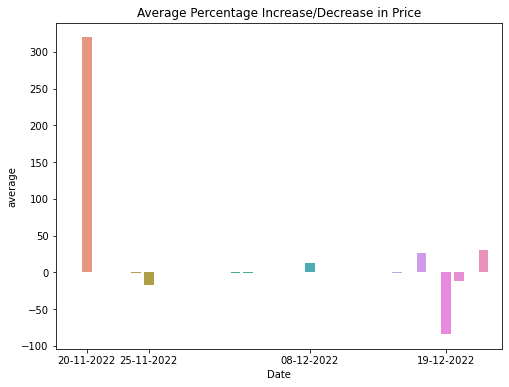

In [16]:
plt.figure(figsize=(8,6))
sns.barplot(data=df_grouped, x='Date', y='average') \
    .set(xticks=[2, 7, 20, 31], xticklabels=['20-11-2022', '25-11-2022', '08-12-2022', '19-12-2022'])
plt.title('Average Percentage Increase/Decrease in Price');

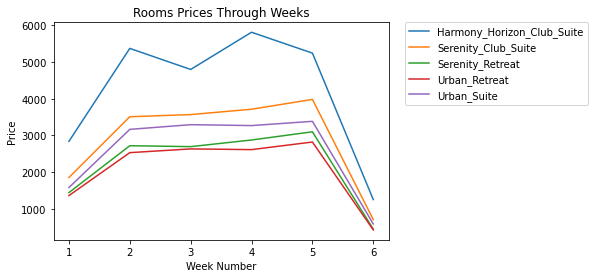

In [17]:
df_mean = pd.DataFrame(df_grouped.groupby([pd.Grouper(key='Date', freq='W'), 
                                           pd.Grouper('Category')])['Price'].mean()).reset_index()

df_mean['Week Number'] = df_mean.Date.dt.isocalendar().week

dic2 = {46:'1', 47:'2', 48:'3', 49:4, 50:'5', 51:'6'}
df_mean = df_mean.replace({'Week Number': dic2})

sns.lineplot(data=df_mean, x='Week Number', y='Price', hue='Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('Rooms Prices Through Weeks');